In [1]:
import math
import os
import dill as pickle
import random

import fasttext
from IPython.core.display import display, HTML
import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
from sklearn.calibration import calibration_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

# Import the Data

In [2]:
df = pd.read_csv(os.path.join("..", "AI_ML_Challenge_Training_Data_Set_1_v1.csv"))
df.head()

,Clause ID,Clause Text,Classification
0,1588,18. Governing Law: This Agreement shall be gov...,0
1,1146,"1.8 Modification. We may modify, update, or di...",1
2,4792,Except as otherwise expressly provided in this...,0
3,2759,8.3. The benefit and burdens of this Ag...,1
4,4400,DEFINITIONS,0


# Viz Functions

In [3]:
# functions for plotting classification results
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, y_scores, y_test, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print("="*80)
    print("Operating point = {:.3f}".format(t),end="\n\n")
    print("Confusion Matrix:")
    print(pd.DataFrame(metrics.confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_red', 'pred_gree'], 
                       index=['Compliant', 'Non-Compliant']),end="\n\n")
    print("Classification Report:")
    print(metrics.classification_report(y_test, y_pred_adj, target_names=['Compliant', 'Non-Compliant']))
    
    
    font = {'family' : 'normal',
            'weight' : 'medium',
            'size'   : 18}

    plt.rc('font', **font)
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold",fontdict=font)
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.0, 1.01]);
    plt.xlim([0.0, 1.01]);
    plt.xlabel('Recall',fontdict=font);
    plt.ylabel('Precision',fontdict=font);
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)
    
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    recall_precision_delta = [abs(r - p) for r, p in zip(precisions, recalls)]
    min_delta = min(recall_precision_delta)
    min_delta_ix = recall_precision_delta.index(min_delta)
    optimal_threshold = thresholds[min_delta_ix]
    print(f"Optimal Operating Point: {optimal_threshold}")
    
    font = {'family' : 'normal',
            'weight' : 'medium',
            'size'   : 18}

    plt.rc('font', **font)
    
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the operating point",fontdict=font)
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot((optimal_threshold, optimal_threshold), (0, 1), "r--", label="Optimal Operating Point")
    plt.ylabel("Score",fontdict=font)
    plt.xlabel("Operating Point",fontdict=font)
    plt.legend(loc='best',fontsize=16)
    
def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')
    
def plot_fpr_recall_vs_threshold(y_test, y_scores):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]
    
    
    fpr, tpr, roc_thresh = metrics.roc_curve(y_test, y_scores)
    p, r, prc_thresh = metrics.precision_recall_curve(y_test, y_scores)
    
    font = {'family' : 'normal',
            'weight' : 'medium',
            'size'   : 18}

    plt.rc('font', **font)
   
    plt.figure(figsize=(8, 8))
    plt.title("False Positive and Recall Scores as a function of the operating point",fontdict=font)

    plt.plot(prc_thresh, r[:-1], "b--", label="Recall")
    plt.plot(roc_thresh, fpr, "g-", label="FPR")
    
    #plot vertical line where recall is highest (i.e. == 1)
    x_text = prc_thresh[0]
    plt.axvline(x=x_text)
    #plot horizontal line that will intersect where the vertical line hits the fpr line
    y_text = fpr[np.where(roc_thresh==find_nearest(roc_thresh, prc_thresh[0]))[0][0]]
    plt.axhline(y=y_text)
    x = round(x_text,2)
    y = round(y_text,2)
    plt.text(x_text,y_text,"({}, {})".format(x, y))
    plt.ylabel("Score")
    plt.xlabel("Operating Point")
    plt.legend(loc='best',fontsize=16)
    
def plot_prc(y_score, y_test):
    """
    Plot the precision-recall curve, labeled with average precision.
    """
    average_precision = metrics.average_precision_score(y_test, y_score)

    precision, recall, _ = metrics.precision_recall_curve(y_test, y_score)
    #plot it
    plt.figure(figsize=(8,8))
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall',fontsize=16)
    plt.ylabel('Precision',fontsize=16)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision),fontsize=20)
    
def plot_calibration_curve(y_true, y_prob):
    fraction_of_positives, mean_predicted_value = calibration_curve(y_true, y_prob)
    bs = metrics.brier_score_loss(y_true, y_prob)
    fig = plt.figure(1, figsize=(10, 10))
    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    plt.plot(mean_predicted_value, fraction_of_positives, label="%s (%1.3f)" % ("Brier Score", bs))

    plt.ylabel("Fraction of positives")
    plt.ylim([-0.05, 1.05])
    plt.legend(loc="lower right")
    plt.title('Calibration plots  (reliability curve)')

# Linear Model Visualizations

These visuals will help evaluate the performance of the linear model (Support Vector Machine or Logistic Regression) used by the Stochastic Gradient Descent learner.

In [4]:
# the loss='log' tells us it was logistic regression
model = joblib.load(os.path.join("estimators", "sgd.joblib"))
model.steps

[('tfidf',
  TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.float64'>, encoding='utf-8',
                  input='content', lowercase=True, max_df=1.1503017331662995,
                  max_features=None, min_df=2, ngram_range=(1, 2), norm='l2',
                  preprocessor=None, smooth_idf=True, stop_words=None,
                  strip_accents=None, sublinear_tf=False,
                  token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                  vocabulary=None)),
 ('lsa',
  OptionalTruncatedSVD(algorithm='randomized', n_components=977, n_iter=5,
                       passthrough=True, random_state=None, tol=0.0)),
 ('clf',
  SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
                early_stopping=False, epsilon=0.07301393685975939, eta0=0.0,
                fit_intercept=True, l1_ratio=0.15, learning_rate='optimal',
                loss='log', max_iter=1212, n_iter_no_chang

In [5]:
df['y_pred'] = model.predict(df['Clause Text'])
df['y_score'] = model.predict_proba(df['Clause Text'])[:,1]

## Classifcation Report

In [6]:
cm = metrics.classification_report(
    df['Classification'],
    df['y_pred'],
    target_names=['Compliant', 'Non-Compliant']
)
print(cm)

               precision    recall  f1-score   support

    Compliant       0.99      0.89      0.94      6407
Non-Compliant       0.66      0.96      0.78      1472

     accuracy                           0.90      7879
    macro avg       0.82      0.92      0.86      7879
 weighted avg       0.93      0.90      0.91      7879



## ROC Curve
ROC curves feature the true positive rate on the y-axis and the false positive rate on the x-axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

The “steepness” of ROC curves is also important, since it is ideal to maximize the true positive rate while minimizing the false positive rate.

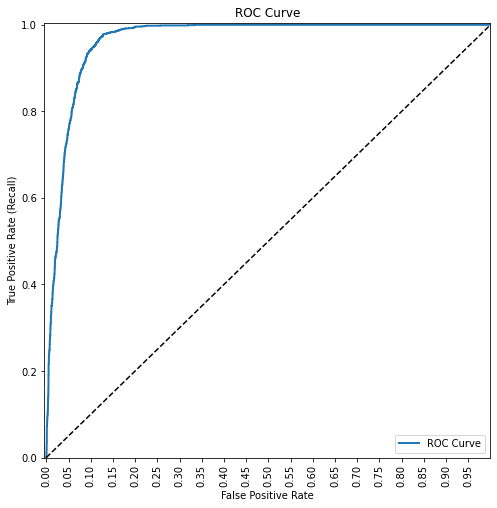

In [7]:
fpr, tpr, auc_thresholds = metrics.roc_curve(df['Classification'], df['y_score'])
plot_roc_curve(fpr, tpr, 'ROC Curve')

Although this plot looks good, we should ignore it. For imbalanced classification problems like ours, the ROC AUC can be misleading. This is because a small number of correct or incorrect predictions can result in a large change in the ROC Curve or ROC AUC score. A common alternative is the precision-recall curve and area under curve.

## PRC AUC

**Precision** is a metric that quantifies the number of correct positive predictions made.

It is calculated as the number of true positives divided by the total number of true positives and false positives.

 - Precision = TruePositives / (TruePositives + FalsePositives)
 - The result is a value between 0.0 for no precision and 1.0 for full or perfect precision.

**Recall** is a metric that quantifies the number of correct positive predictions made out of all positive predictions that could have been made.

It is calculated as the number of true positives divided by the total number of true positives and false negatives (e.g. it is the true positive rate).

 - Recall = TruePositives / (TruePositives + FalseNegatives)
 - The result is a value between 0.0 for no recall and 1.0 for full or perfect recall.
 
 
Both the precision and the recall are focused on the positive class (the minority class) and are unconcerned with the true negatives (majority class).

A precision-recall curve (or PR Curve) is a plot of the precision (y-axis) and the recall (x-axis) for different probability thresholds. The focus of the PR curve on the minority class makes it an effective diagnostic for imbalanced binary classification models, so we'll use it.

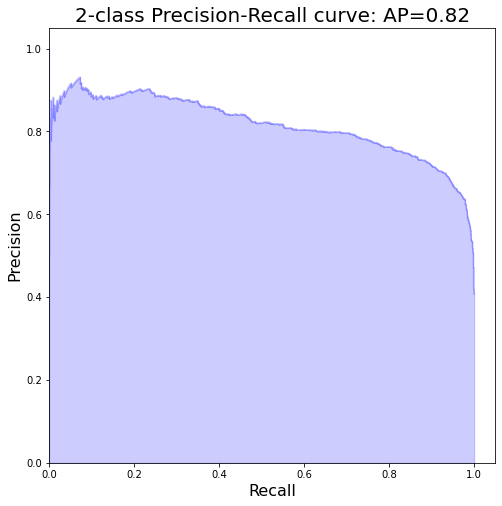

In [8]:
plot_prc(df['y_score'], df['Classification'])

## Threshold Adjusting

Since we're interested in tradeoffs between precision and recall, we can visualize the tradeoff when the probability threshold for the estimator's decision (50% by default) is adjusted. When treating the thresholding in such a fashion, it's referred to as the model's **operating point**.

Below, we'll look at operating points of $0.4 , 0.45, 0.5 , 0.55, 0.6$

Operating point = 0.400

Confusion Matrix:
               pred_red  pred_gree
Compliant          5206       1201
Non-Compliant        11       1461

Classification Report:
               precision    recall  f1-score   support

    Compliant       1.00      0.81      0.90      6407
Non-Compliant       0.55      0.99      0.71      1472

     accuracy                           0.85      7879
    macro avg       0.77      0.90      0.80      7879
 weighted avg       0.91      0.85      0.86      7879

Operating point = 0.450

Confusion Matrix:
               pred_red  pred_gree
Compliant          5463        944
Non-Compliant        25       1447

Classification Report:
               precision    recall  f1-score   support

    Compliant       1.00      0.85      0.92      6407
Non-Compliant       0.61      0.98      0.75      1472

     accuracy                           0.88      7879
    macro avg       0.80      0.92      0.83      7879
 weighted avg       0.92      0.88      0.89  

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


               precision    recall  f1-score   support

    Compliant       0.98      0.91      0.94      6407
Non-Compliant       0.70      0.92      0.80      1472

     accuracy                           0.91      7879
    macro avg       0.84      0.92      0.87      7879
 weighted avg       0.93      0.91      0.92      7879

Operating point = 0.600

Confusion Matrix:
               pred_red  pred_gree
Compliant          5964        443
Non-Compliant       209       1263

Classification Report:
               precision    recall  f1-score   support

    Compliant       0.97      0.93      0.95      6407
Non-Compliant       0.74      0.86      0.79      1472

     accuracy                           0.92      7879
    macro avg       0.85      0.89      0.87      7879
 weighted avg       0.92      0.92      0.92      7879



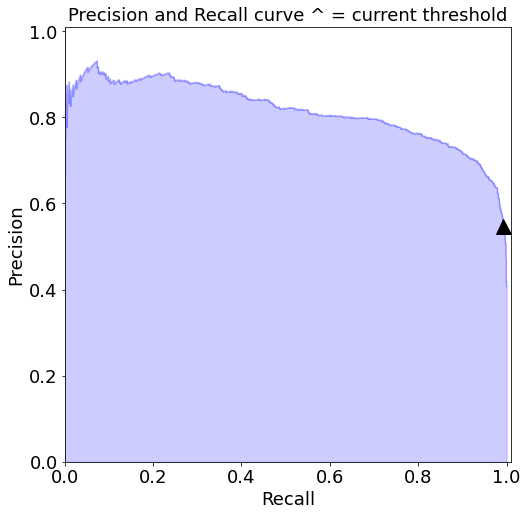

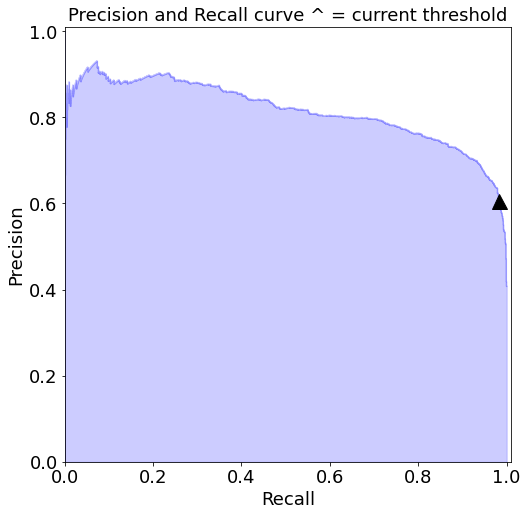

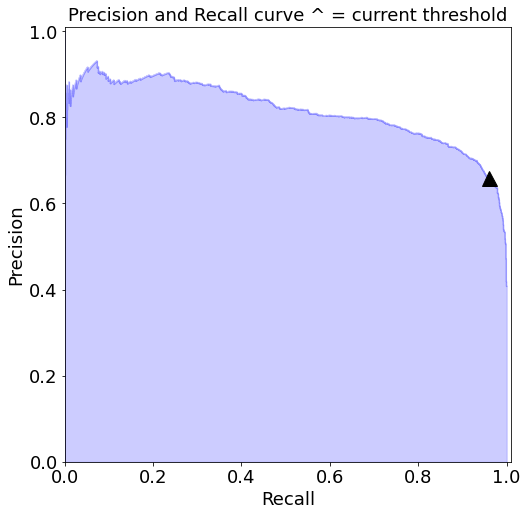

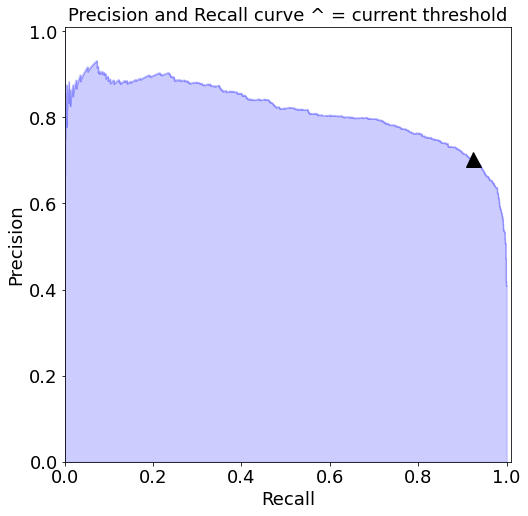

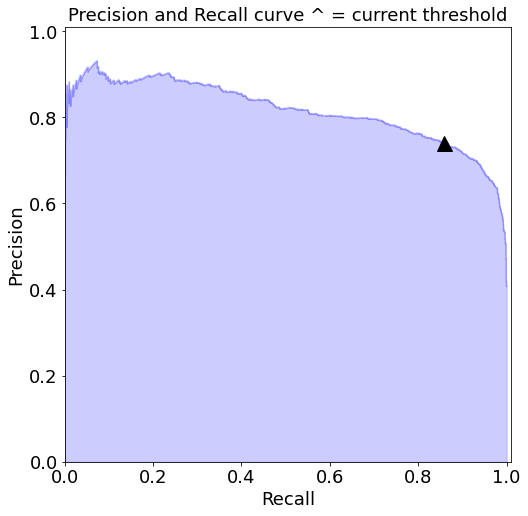

In [9]:
p, r, thresholds = metrics.precision_recall_curve(df['Classification'], df['y_score'])
for i in np.linspace(.4, .6, 5):
    precision_recall_threshold(p, r, thresholds, df['y_score'], df['Classification'], t=i)

As the operating point increases, we see precision for the majority class - i.e. Compliant - decrease while precision for the minority class - i.e Non-Compliant - increases. The inverse happens to recall. The point of this exercise is to demonstrate that business values - e.g. a low false positive rate - can be prioritized by adjusting the operating point, but obviously with a cost.

To help make the optimal decision for choosing an operating point, it's possible to plot precision and recall as a function of the operating point. Finding the intersection of these two curves maximizes their values (assuming you value precision the same as recall).

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Optimal Operating Point: 0.650921373070175


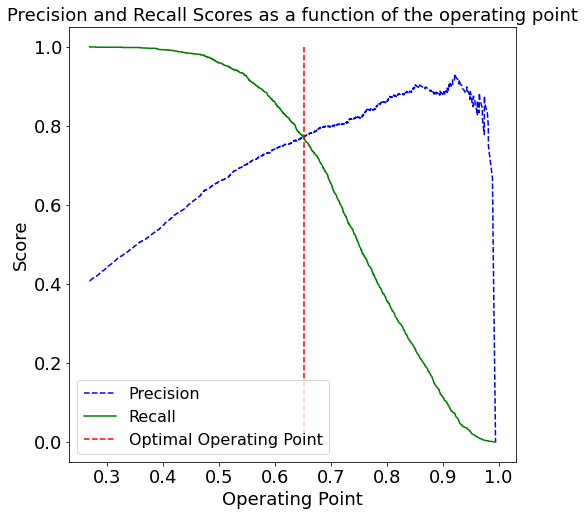

In [10]:
plot_precision_recall_vs_threshold(p, r, thresholds)

## Calibration Curve
Adjusting the operating point only makes sense if the model is properly calibrated.

In a calibration curve, the x-axis represents the average predicted probability in each bin. The y-axis is the fraction of positives, i.e. the proportion of samples whose class is the positive class (in each bin). In short, it's a line plot of the relative frequency of what was observed (y-axis) versus the predicted probability frequency (x-axis). For a perfect model, you'd expect to see a calibration curve that forms a 45-degree diaganol starting at the origin and moving north-east. When the line is below the diagonal, the model has predicted non-compliant when it should have predicted compliant (i.e. the probabilities are too large). When the line is above the diagonal, the model has predicted compliant when it should have predicted non-compliant (i.e. the probabilities are too small).

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


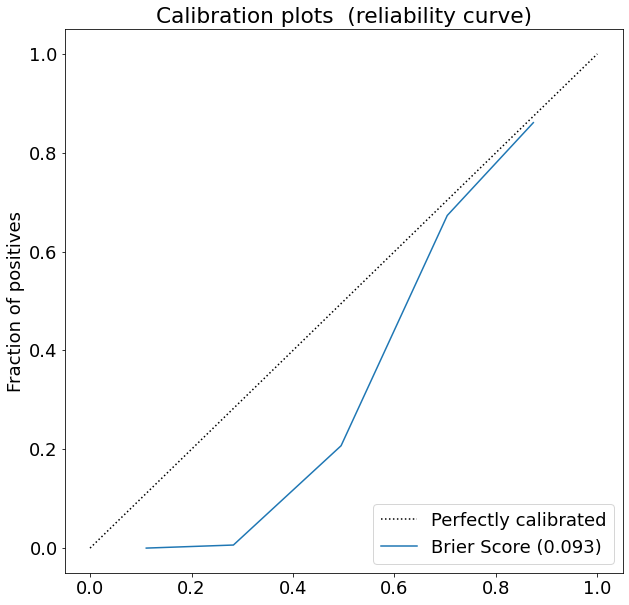

In [11]:
plot_calibration_curve(df['Classification'], df['y_score'])

Since this lies under the diagonal, the model is predicting non-compliant too frequently. Above, we saw that our optimal operating point was $.650921373070175$. If we change our operating point to $.65$, we'll increase precision for the positive class (i.e. Non-compliant) at the expense of precision for the negative class (i.e. Compliant). This will, however, lead to the inverse for recall. Let's see the calibration curve if we adjust the operating point.

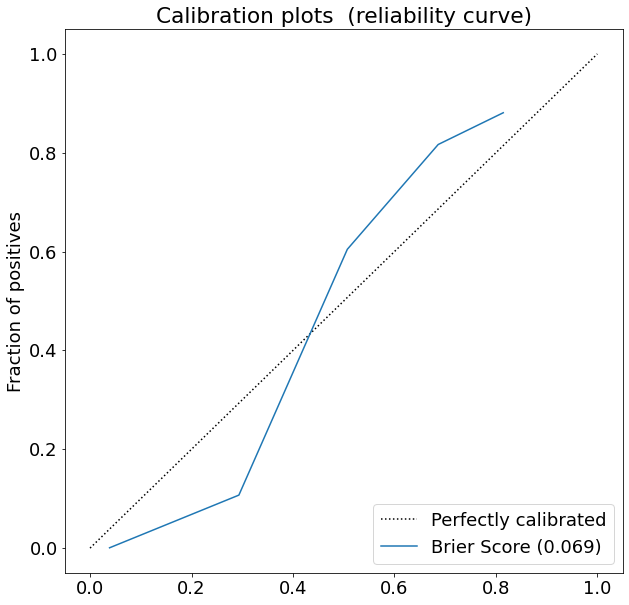

In [12]:
plot_calibration_curve(
    df['Classification'],
    np.clip(df['y_score'] - .15, 0, 1) #  .15 = .65 - .5
)

In [13]:
metrics.f1_score(df['Classification'], df['y_pred'])

0.7818383167220377

In [14]:
adjusted_y_pred = [0 if i < .5 else 1 for i in np.clip(df['y_score'] - .15, 0, 1)]
metrics.f1_score(df['Classification'], adjusted_y_pred)

0.7724652424550695

**The result brings the curve closer to the diagnol when it is below the line predicting compliant, but also brings it above the diagonal when it is predicting non-compliant. Nevertheless, the new operating point lowers the brier score and also increases the f1-score.**

# Gradient Boosting Classifier Visualizations

In [15]:
model = joblib.load(os.path.join("estimators", "gbc.joblib"))

In [16]:
model.steps

[('tfidf',
  TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.float64'>, encoding='utf-8',
                  input='content', lowercase=True, max_df=1.0244397916892212,
                  max_features=None, min_df=1, ngram_range=(1, 1), norm='l2',
                  preprocessor=None, smooth_idf=True, stop_words=None,
                  strip_accents=None, sublinear_tf=False,
                  token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                  vocabulary=None)),
 ('lsa',
  OptionalTruncatedSVD(algorithm='randomized', n_components=2560, n_iter=5,
                       passthrough=True, random_state=None, tol=0.0)),
 ('clf',
  GradientBoostingClassifier(criterion='friedman_mse', init=None,
                             learning_rate=0.09537394676409655, loss='deviance',
                             max_depth=28, max_features='auto',
                             max_leaf_nodes=None, min_impurity_decrea

In [17]:
df['y_pred'] = model.predict(df['Clause Text'])
df['y_score'] = model.predict_proba(df['Clause Text'])[:,1]

## Classification Report

In [18]:
cm = metrics.classification_report(
    df['Classification'],
    df['y_pred'],
    target_names=['Compliant', 'Non-Compliant']
)
print(cm)

               precision    recall  f1-score   support

    Compliant       0.98      1.00      0.99      6407
Non-Compliant       0.99      0.92      0.95      1472

     accuracy                           0.98      7879
    macro avg       0.98      0.96      0.97      7879
 weighted avg       0.98      0.98      0.98      7879



## ROC Curve

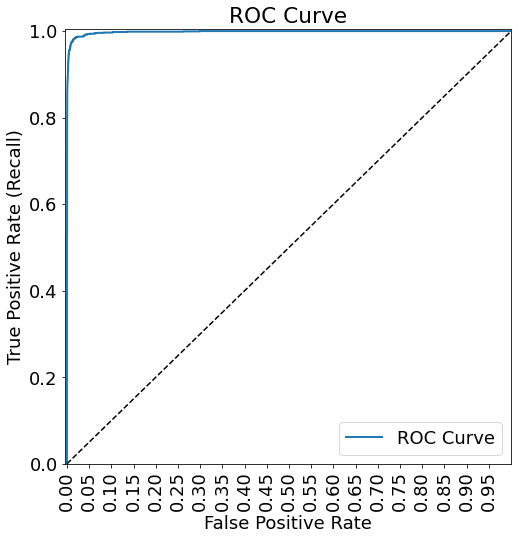

In [19]:
fpr, tpr, auc_thresholds = metrics.roc_curve(df['Classification'], df['y_score'])
plot_roc_curve(fpr, tpr, 'ROC Curve')

## PRC AUC

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


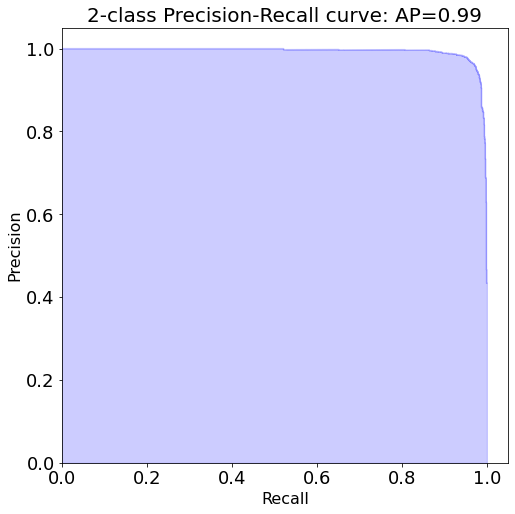

In [20]:
plot_prc(df['y_score'], df['Classification'])

## Threshold Adjusting

Operating point = 0.400

Confusion Matrix:
               pred_red  pred_gree
Compliant          6354         53
Non-Compliant        48       1424

Classification Report:
               precision    recall  f1-score   support

    Compliant       0.99      0.99      0.99      6407
Non-Compliant       0.96      0.97      0.97      1472

     accuracy                           0.99      7879
    macro avg       0.98      0.98      0.98      7879
 weighted avg       0.99      0.99      0.99      7879

Operating point = 0.450

Confusion Matrix:
               pred_red  pred_gree
Compliant          6379         28
Non-Compliant        78       1394

Classification Report:
               precision    recall  f1-score   support

    Compliant       0.99      1.00      0.99      6407
Non-Compliant       0.98      0.95      0.96      1472

     accuracy                           0.99      7879
    macro avg       0.98      0.97      0.98      7879
 weighted avg       0.99      0.99      0.99  

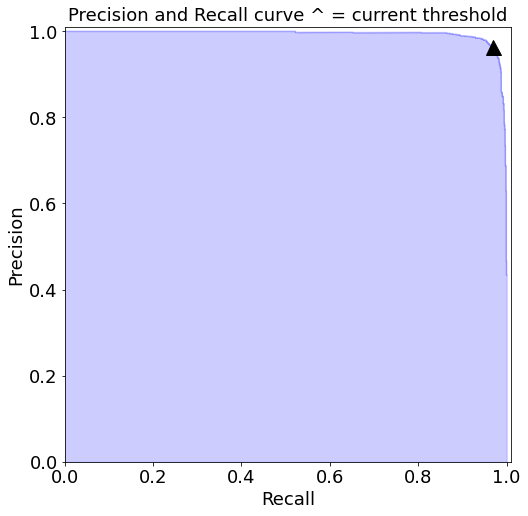

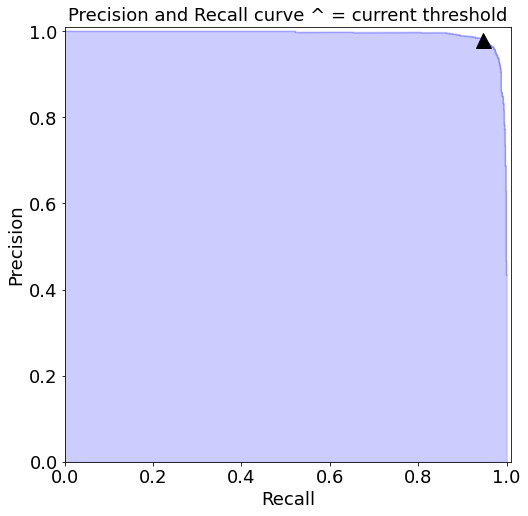

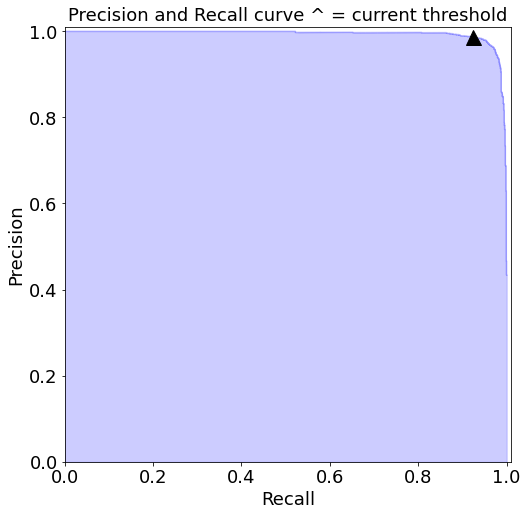

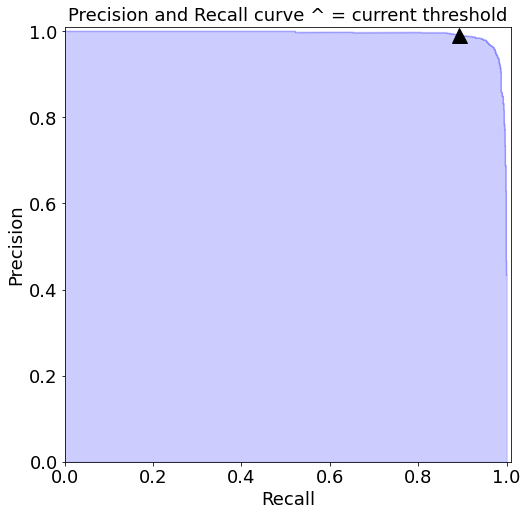

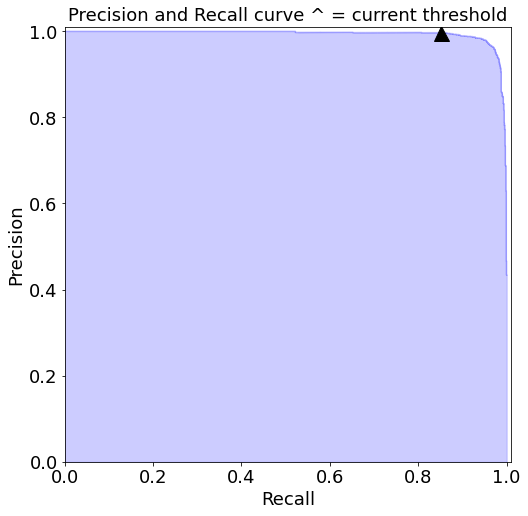

In [21]:
p, r, thresholds = metrics.precision_recall_curve(df['Classification'], df['y_score'])
for i in np.linspace(.4, .6, 5):
    precision_recall_threshold(p, r, thresholds, df['y_score'], df['Classification'], t=i)

Optimal Operating Point: 0.4052118831568769


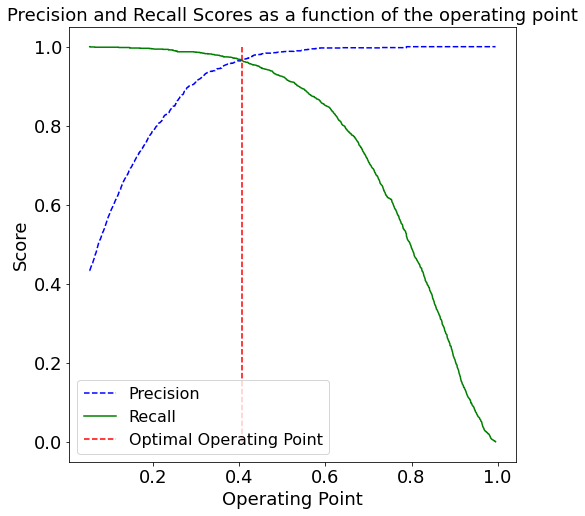

In [22]:
plot_precision_recall_vs_threshold(p, r, thresholds)

## Calibration Curve

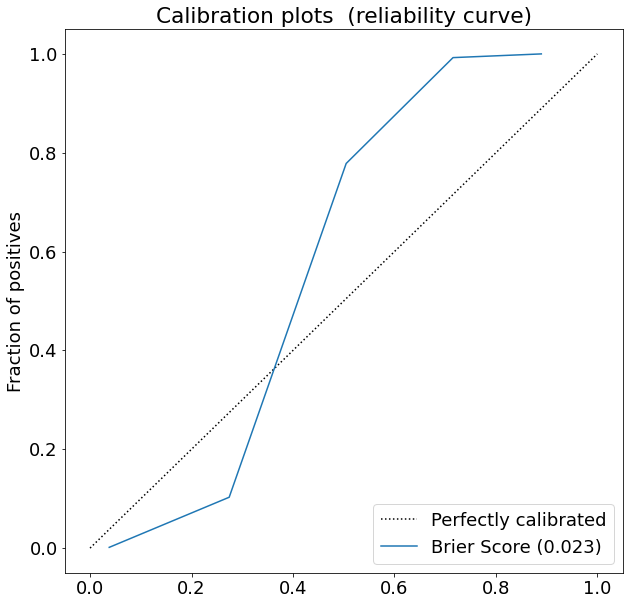

In [23]:
plot_calibration_curve(df['Classification'], df['y_score'])

# Random Forest Visualizations

In [24]:
model = joblib.load(os.path.join("estimators", "rfc.joblib"))
model.steps

[('tfidf',
  TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                  dtype=<class 'numpy.float64'>, encoding='utf-8',
                  input='content', lowercase=True, max_df=1.1101657945094883,
                  max_features=None, min_df=1, ngram_range=(1, 1), norm='l2',
                  preprocessor=None, smooth_idf=True, stop_words=None,
                  strip_accents=None, sublinear_tf=False,
                  token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                  vocabulary=None)),
 ('lsa',
  OptionalTruncatedSVD(algorithm='randomized', n_components=1335, n_iter=5,
                       passthrough=True, random_state=None, tol=0.0)),
 ('clf',
  RandomForestClassifier(bootstrap=True, class_weight='balanced',
                         criterion='entropy', max_depth=47, max_features='auto',
                         max_leaf_nodes=None, min_impurity_decrease=0.0,
                         min_impurity_split=None,
          

In [25]:
df['y_pred'] = model.predict(df['Clause Text'])
df['y_score'] = model.predict_proba(df['Clause Text'])[:,1]

## Classification Report

In [26]:
cm = metrics.classification_report(
    df['Classification'],
    df['y_pred'],
    target_names=['Compliant', 'Non-Compliant']
)
print(cm)

               precision    recall  f1-score   support

    Compliant       0.97      0.89      0.93      6407
Non-Compliant       0.65      0.89      0.75      1472

     accuracy                           0.89      7879
    macro avg       0.81      0.89      0.84      7879
 weighted avg       0.91      0.89      0.90      7879



## ROC Curve

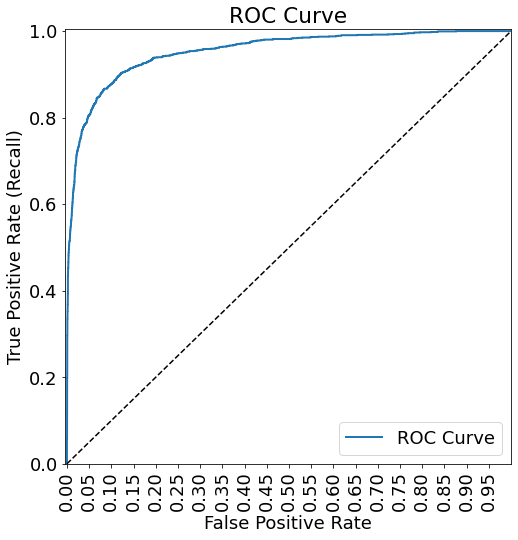

In [27]:
fpr, tpr, auc_thresholds = metrics.roc_curve(df['Classification'], df['y_score'])
plot_roc_curve(fpr, tpr, 'ROC Curve')

## PRC AUC

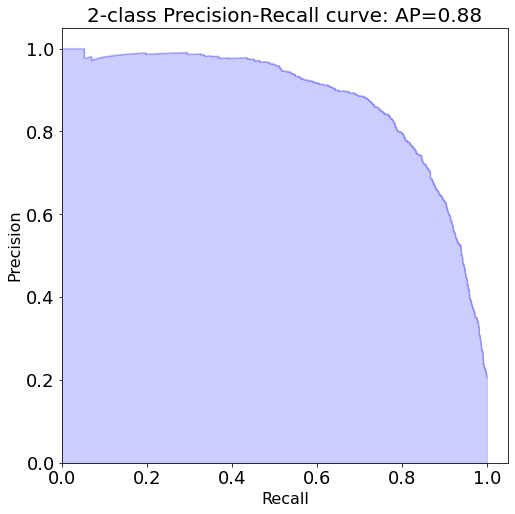

In [28]:
plot_prc(df['y_score'], df['Classification'])

## Threshold Adjusting

Operating point = 0.400

Confusion Matrix:
               pred_red  pred_gree
Compliant          4439       1968
Non-Compliant        62       1410

Classification Report:
               precision    recall  f1-score   support

    Compliant       0.99      0.69      0.81      6407
Non-Compliant       0.42      0.96      0.58      1472

     accuracy                           0.74      7879
    macro avg       0.70      0.83      0.70      7879
 weighted avg       0.88      0.74      0.77      7879

Operating point = 0.450

Confusion Matrix:
               pred_red  pred_gree
Compliant          5159       1248
Non-Compliant        91       1381

Classification Report:
               precision    recall  f1-score   support

    Compliant       0.98      0.81      0.89      6407
Non-Compliant       0.53      0.94      0.67      1472

     accuracy                           0.83      7879
    macro avg       0.75      0.87      0.78      7879
 weighted avg       0.90      0.83      0.85  

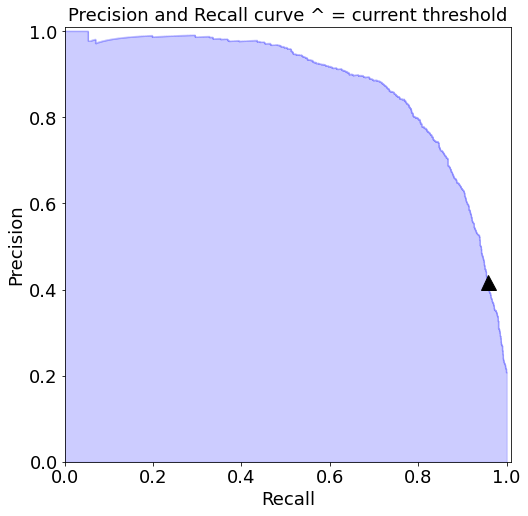

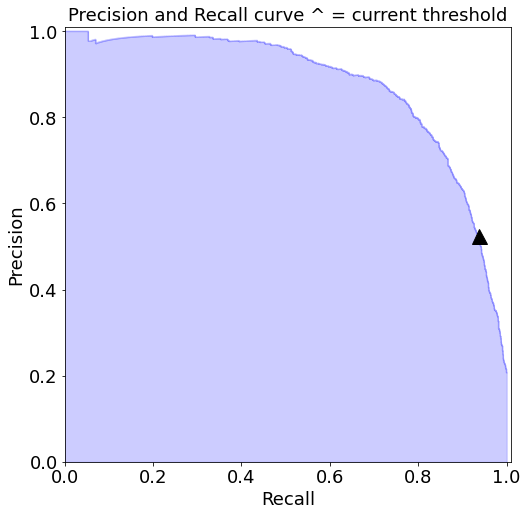

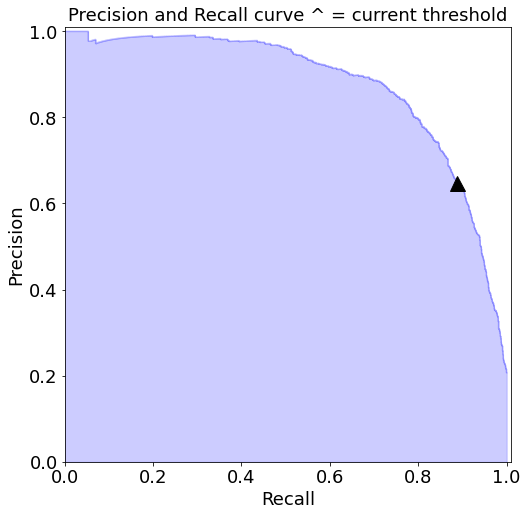

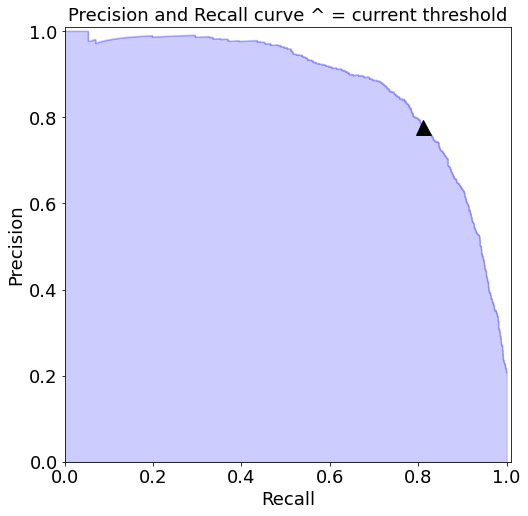

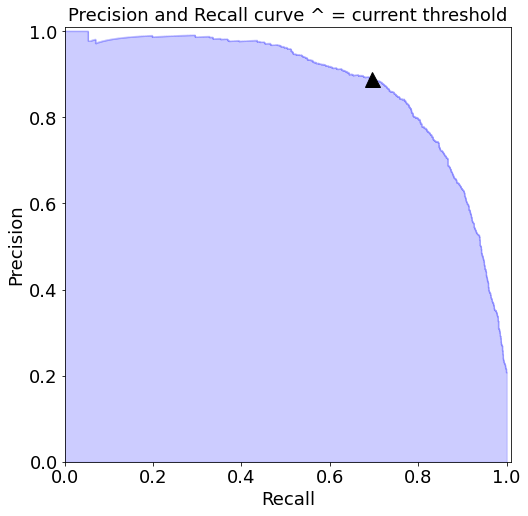

In [29]:
p, r, thresholds = metrics.precision_recall_curve(df['Classification'], df['y_score'])
for i in np.linspace(.4, .6, 5):
    precision_recall_threshold(p, r, thresholds, df['y_score'], df['Classification'], t=i)

Optimal Operating Point: 0.5578145774533633


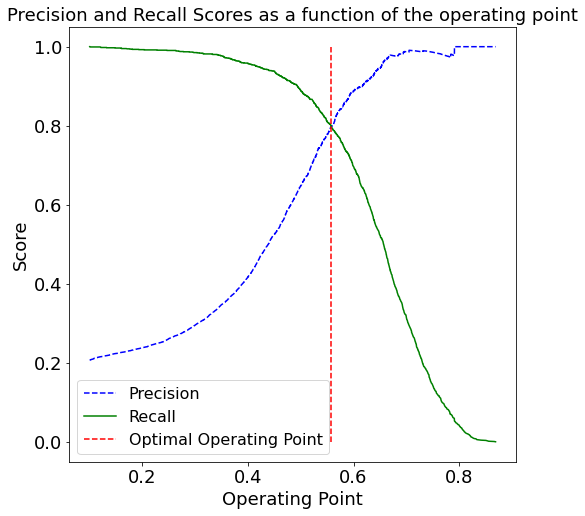

In [30]:
plot_precision_recall_vs_threshold(p, r, thresholds)

## Calibration Curve

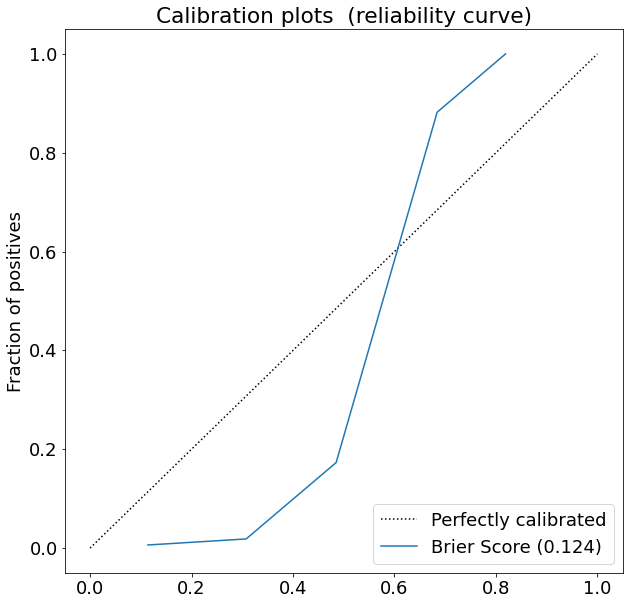

In [31]:
plot_calibration_curve(df['Classification'], df['y_score'])

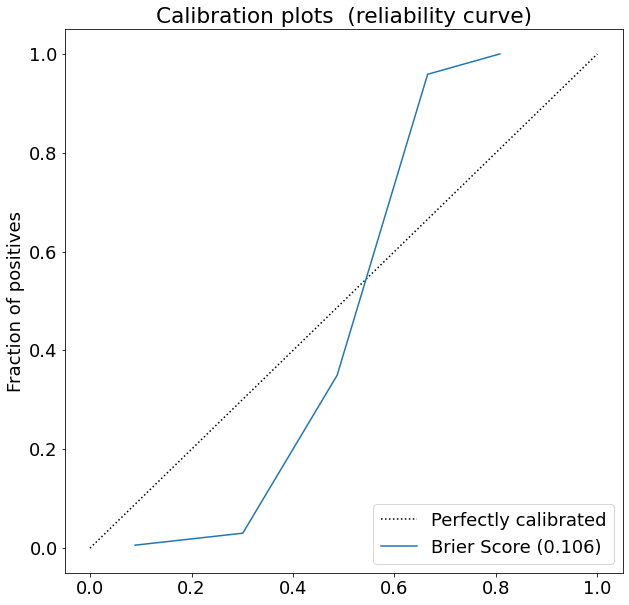

In [32]:
plot_calibration_curve(
    df['Classification'],
    np.clip(df['y_score'] - .0557, 0, 1) #  .15 = .65 - .5
)

# Blazing Text (Word Embedding Model)

In [5]:
model = fasttext.load_model(os.path.join("estimators", "model.bin"))

In [53]:
# tokenize the same way as for training
samples = []
for _, row in df[['Clause Text', 'Classification']].iterrows():
    text, label = row
    tokens = ' '.join(nltk.word_tokenize(text.lower()))
    samples.append((tokens, label))

In [55]:
# same seed used during training
random.seed(123) 
random.shuffle(samples)

n_train = math.ceil(len(samples) * .8)

train = samples[:n_train]
validation = samples[n_train:]

In [56]:
preds, probs = model.predict([v[0] for v in validation])
preds = [p[0][-1] for p in preds]
probs = [p[0] for p in probs]

In [57]:
def fix_prob(prob):
    if prob < 0:
        return 0
    elif prob > 1:
        return 1
    else:
        return prob

In [58]:
parsed_preds = []
for pred, prob in zip(preds, probs):
    parsed_pred = {}
    if pred == '0':
        prob = 1 - prob
    parsed_pred['y_pred'] = pred
    parsed_pred['y_prob'] = fix_prob(prob)
    parsed_preds.append(parsed_pred)

In [65]:
validation_df = pd.DataFrame(parsed_preds)
validation_df['y_true'] = [v[1] for v in validation]
validation_df['y_pred'] = pd.to_numeric(validation_df['y_pred'])
validation_df.head()

,y_pred,y_prob,y_true
0,0,0.004220,0
1,0,0.000000,0
2,1,0.982669,1
3,1,0.794283,1
4,0,0.330306,0


## Classification Report

In [64]:
cm = metrics.classification_report(
    validation_df['y_true'],
    validation_df['y_pred'],
    target_names=['Compliant', 'Non-Compliant']
)
print(cm)

               precision    recall  f1-score   support

    Compliant       0.96      0.99      0.98      1282
Non-Compliant       0.95      0.84      0.89       293

     accuracy                           0.96      1575
    macro avg       0.96      0.91      0.93      1575
 weighted avg       0.96      0.96      0.96      1575



## ROC AUC

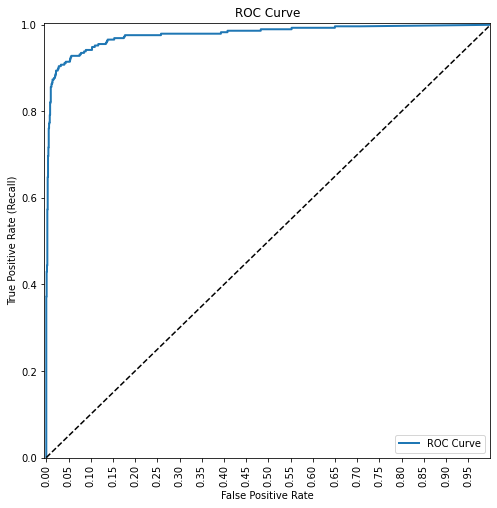

In [66]:
fpr, tpr, auc_thresholds = metrics.roc_curve(validation_df['y_true'], validation_df['y_prob'])
plot_roc_curve(fpr, tpr, 'ROC Curve')

## Precision Recall Curve

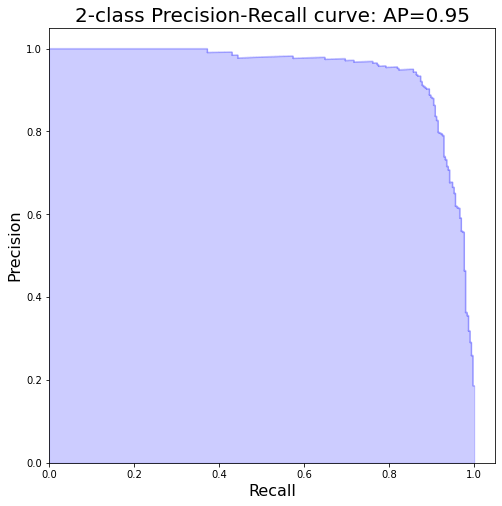

In [67]:
plot_prc(validation_df['y_prob'], validation_df['y_true'])

## Threshold (Operating Point) Adjusting

Operating point = 0.400

Confusion Matrix:
               pred_red  pred_gree
Compliant          1262         20
Non-Compliant        37        256

Classification Report:
               precision    recall  f1-score   support

    Compliant       0.97      0.98      0.98      1282
Non-Compliant       0.93      0.87      0.90       293

     accuracy                           0.96      1575
    macro avg       0.95      0.93      0.94      1575
 weighted avg       0.96      0.96      0.96      1575

Operating point = 0.450

Confusion Matrix:
               pred_red  pred_gree
Compliant          1269         13
Non-Compliant        43        250

Classification Report:
               precision    recall  f1-score   support

    Compliant       0.97      0.99      0.98      1282
Non-Compliant       0.95      0.85      0.90       293

     accuracy                           0.96      1575
    macro avg       0.96      0.92      0.94      1575
 weighted avg       0.96      0.96      0.96  

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


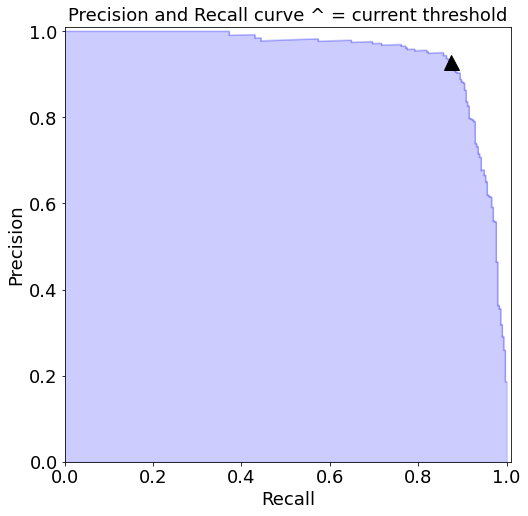

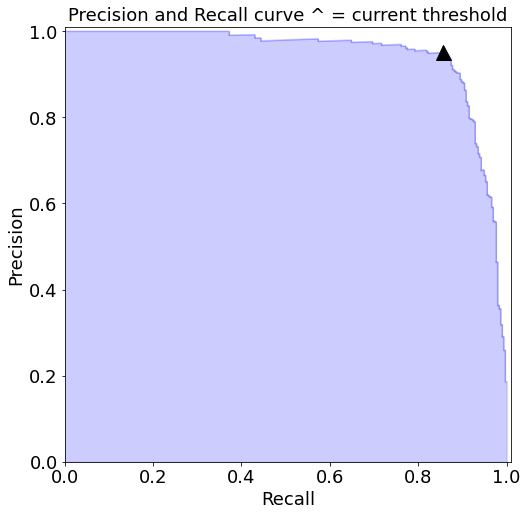

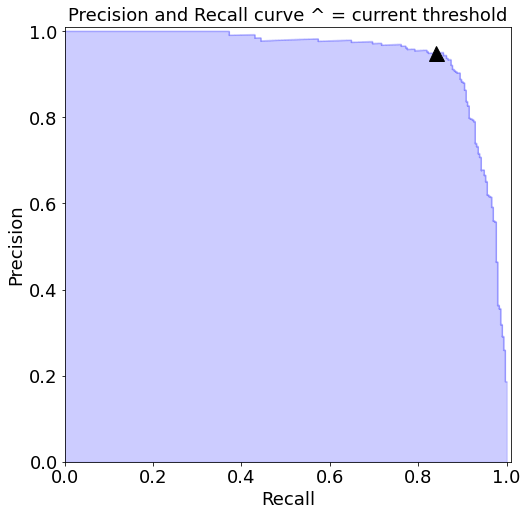

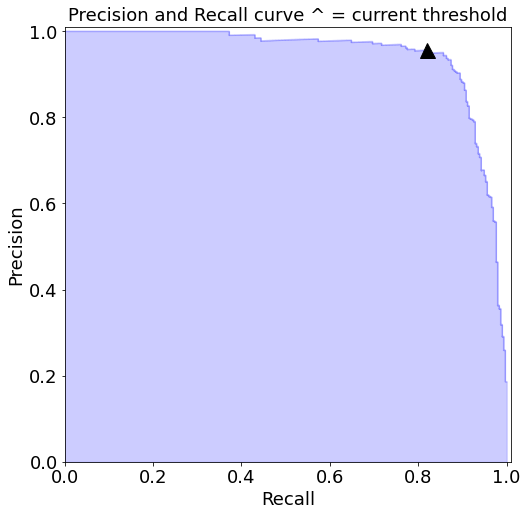

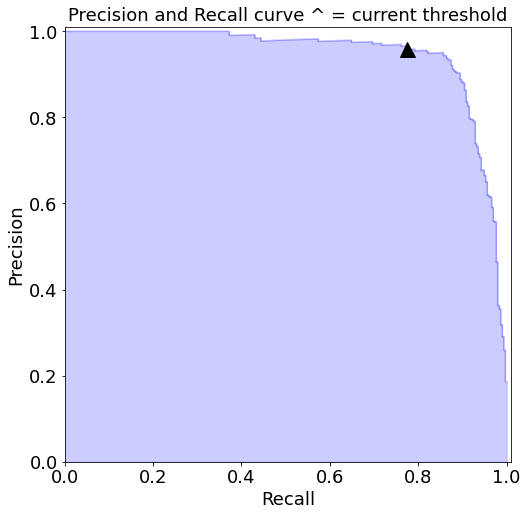

In [68]:
p, r, thresholds = metrics.precision_recall_curve(validation_df['y_true'], validation_df['y_prob'])
for i in np.linspace(.4, .6, 5):
    precision_recall_threshold(p, r, thresholds, validation_df['y_prob'], validation_df['y_true'], t=i)

# Optimal Operating Point

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Optimal Operating Point: 0.3320433497428894


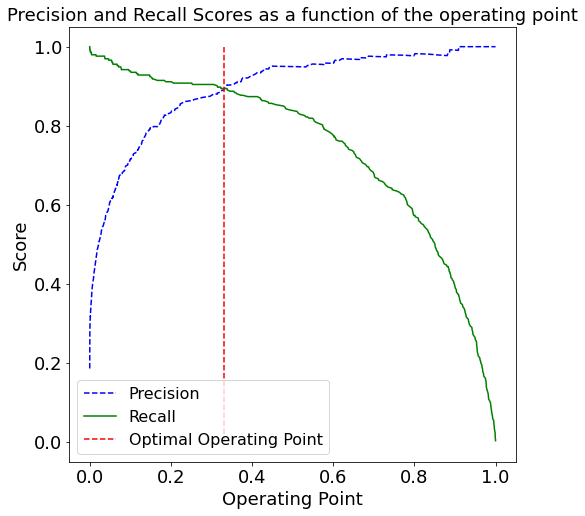

In [69]:
plot_precision_recall_vs_threshold(p, r, thresholds)

## Calibration Curve

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


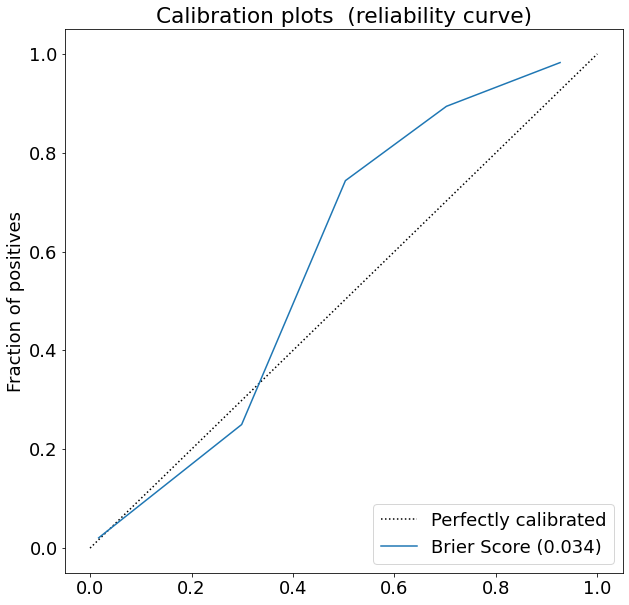

In [70]:
plot_calibration_curve(validation_df['y_true'], validation_df['y_prob'])

## Adjusting to the Optimal Operating Point

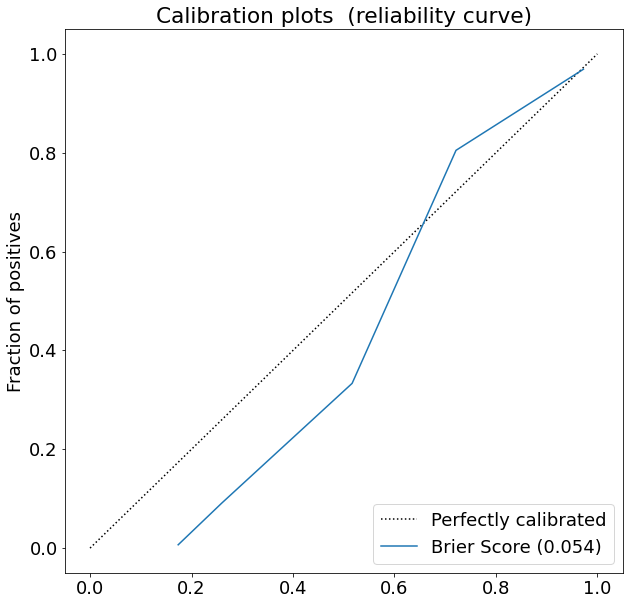

In [71]:
plot_calibration_curve(
    validation_df['y_true'],
    np.clip(validation_df['y_prob'] + (.5 - .33), 0, 1)
)

Although the brier score slightly increases (which makes sense since we are fiddling with the decision point), let's see the f1 score:

In [72]:
# before adjustment
metrics.f1_score(validation_df['y_true'], validation_df['y_pred'])

0.8892921960072595

In [73]:
adjusted_y_pred = [0 if i < .5 else 1 for i in np.clip(validation_df['y_prob'] + (.5 - .33), 0, 1)]
metrics.f1_score(validation_df['y_true'], adjusted_y_pred)

0.8926746166950597

We get a slight improvement to the f1-score and a loss in the brier score, which I'd say is well worth it.

## Feature Importance
The word-embedding model doesn't provide a straightforward method to visualize feature importances like the tf-idf models. For those other models, it's possible to map each input word its location in the tf-idf matrix and then to use the index from that matrix to find the associated weight in the model.

Since a word embedding model uses a hidden layer neural network architecture, this isn't possible, although it is still a probababilistic model due to the final softmax layer. 

To get an idea for how individual words influenced a prediction, we need to think about the distance (in a hyper-plane) between individual words' word embedding representations and the mean tf-idf weighted word embedding vector of all of the positive samples in the training data set. 

To do this, we can use the cosine similarity as our distance metric. Intuitively, this will determine how similar each word in a clause is to the corpus of non-compliant clauses. The cosine similarity value can be interpreted as follows:

 - −1 value will indicate strongly opposite vectors
 - 0 independent (orthogonal) vectors
 - 1 similar (positive co-linear) vectors. Intermediate values are used to assess the degree of similarity.

In [188]:
pos_samples = [s for s in samples if s[1] == 1]
vec = TfidfVectorizer(tokenizer=lambda x: model.get_line(x)[0])
vec.fit([s[0] for s in pos_samples])
X = vec.transform([s[0] for s in pos_samples])

feature_names = vec.get_feature_names()

In [299]:
with open('vec.pkl', 'wb') as f:
    pickle.dump(vec, f)

In [191]:
sentence_vectors = []

mean_clause_vecs = []
for i, clause in enumerate(pos_samples):
    tokens = model.get_line(clause[0])[0]
    clause_token_vecs = []
    
    feature_index = X[i, :].nonzero()[1]
    tfidf_scores = zip(feature_index, [X[i, x] for x in feature_index])
    token_tfidf_map = {feature_names[i]: s for i, s in tfidf_scores}
    
    for token in tokens:
        token_vec = model.get_word_vector(token).reshape(1, -1)
        tf_idf_weight = token_tfidf_map[token]
        token_vec *= tf_idf_weight
        clause_token_vecs.append(token_vec)
    mean_clause_vec = np.mean(clause_token_vecs, axis=0)
    mean_clause_vecs.append(mean_clause_vec)

In [190]:
mean_vec = np.mean(mean_clause_vecs, axis=0)

In [289]:
np.save("mean_pos_sample_tfidf_vec.npy", mean_vec)

In [291]:
test_sentence = df[df['Classification'] == 1]['Clause Text'].iloc[10]

token_to_sim = []
for token in model.get_line(test_sentence)[0]:
    
    token_vec = model.get_word_vector(token).reshape(1, -1)
    
    dense_token_tfidf_vec = vec.transform([token]).todense()
    token_tfidf = np.where(dense_token_tfidf_vec>0)[-1][-1]
    token_vec *= token_tfidf
    
    sim = metrics.pairwise.cosine_similarity(
        mean_vec.reshape(1, -1),
        token_vec   
    )
    
    token_to_sim.append((token, sim))

In [292]:
token_to_sim

[('Company', array([[0.]], dtype=float32)),
 ('Service', array([[0.]], dtype=float32)),
 ('fees', array([[0.9378721]], dtype=float32)),
 ('are', array([[0.94130087]], dtype=float32)),
 ('quoted', array([[0.93132246]], dtype=float32)),
 ('and', array([[0.7132601]], dtype=float32)),
 ('payable', array([[0.47350374]], dtype=float32)),
 ('to', array([[-0.58195037]], dtype=float32)),
 ('Company', array([[0.]], dtype=float32)),
 ('in', array([[-0.86358935]], dtype=float32)),
 ('US', array([[0.]], dtype=float32)),
 ('currency', array([[0.93040806]], dtype=float32)),
 ('only.', array([[0.]], dtype=float32)),
 ('Fees', array([[0.]], dtype=float32)),
 ('shall', array([[0.9216411]], dtype=float32)),
 ('be', array([[0.928914]], dtype=float32)),
 ('due', array([[0.840398]], dtype=float32)),
 ('and', array([[0.7132601]], dtype=float32)),
 ('payable', array([[0.47350374]], dtype=float32)),
 ('at', array([[0.9381939]], dtype=float32)),
 ('the', array([[0.17119756]], dtype=float32)),
 ('beginning', arr

We now have a mapping of tokens and the cosine similarity between their tf-idf weighted word embedding and that of  the corpus of positive samples. This allows to to back into the hidden layer's decision process.

In [286]:
sim=.02
lightness = np.clip(round(1 - abs(sim), 2) * 100, 50, 97)
lightness

97.0

In [293]:
elems = ''

for token, sim in token_to_sim:
    sim = sim[0][0]
    opacity = np.clip(abs(sim), .5, 1)
    hue = 0 if sim < 0 else 120
    lightness = np.clip(round(1 - abs(sim), 2) * 100, 50, 97)
    
    elem = (
        f'<span style="background-color: hsl({hue}, 100.00%, {lightness}%);'
        f' opacity: {opacity}" title="{sim}">{token}</span>'
    )
    
    elems += elem + ' '


display(HTML(elems))

# Summary